In [1]:
%matplotlib inline
import os
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import torchvision.transforms as transforms
from torchvision.utils import save_image, make_grid

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch
from time import sleep
from IPython import display

os.makedirs('images_2', exist_ok=True)


n_epochs = 3
batch_size = 64
lr = 0.0002
b1 = 0.5 # adam: decay of first order momentum of gradient
b2 = 0.999 #adam: decay of first order momentum of gradient
n_cpu = 8
latent_dim = 100
img_size=28
channels=1
sample_interval=200 # interval betwen image samples


img_shape = (channels, img_size, img_size)
cuda = True if torch.cuda.is_available() else False


In [60]:
# m = nn.Sigmoid()
# loss = nn.BCELoss()
# # input = torch.randn(3, requires_grad=True)
# y =  Tensor(1, 1).fill_(1.0)
# x =  Tensor(1, 1).fill_(0.5)
# o = -y * np.log(x) + (1-y) * np.log(1-x)
# output = loss(x,y)
# print(output, o)
#output.backward()
#print(target, m(input))

tensor(0.6931) tensor([[0.6931]])


In [5]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 768),
            nn.Linear(768, int(np.prod(img_shape))),
            nn.Tanh()
        )
        
    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *img_shape)
        return img



In [2]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)

        return validity


[Epoch 2/3] [Batch 924/938] [D loss: 0.458789] [G loss: 0.721179]


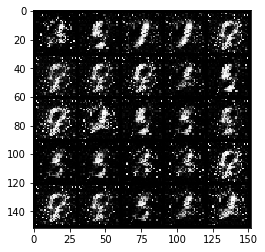

In [6]:
# Loss function
adversarial_loss = torch.nn.BCELoss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

# Configure data loader
os.makedirs('./data/mnist', exist_ok=True)
dataloader = torch.utils.data.DataLoader(
    datasets.MNIST('./data/mnist', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                   ])),
    batch_size=batch_size, shuffle=True)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

# ----------
#  Training
# ----------

for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(dataloader):
        
        # Adversarial ground truths
        valid = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False)


        # Configure input
        real_imgs = Variable(imgs.type(Tensor))

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim))))
#         print(z.size(), i)
        
        # Generate a batch of images
        gen_imgs = generator(z)
        
#         print(gen_imgs.size())
        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
#         print(real_imgs.size(), valid.size())
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()


        batches_done = epoch * len(dataloader) + i
        if batches_done % sample_interval == 0:
            grid_img = make_grid(gen_imgs.data[:25], nrow=5, normalize=True)
            plt.imshow(grid_img.permute(1, 2, 0))
            display.display(plt.gcf())
            display.clear_output(wait=True)
            sleep(1)
            
            print ("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]" % (epoch, n_epochs, i, len(dataloader),
                                                            d_loss.item(), g_loss.item()))

            save_image(gen_imgs.data[:25], 'images/%d.png' % batches_done, nrow=5, normalize=True)
        